In [ ]:
import platform, os, torch
print("Python:", platform.python_version())
print("Torch:", torch.__version__)

mps_ok = hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
device = "mps" if mps_ok else ("cuda" if torch.cuda.is_available() else "cpu")
print("MPS available:", mps_ok)
print("Using device:", device)

# Keep CPU threads reasonable so decoding doesn't starve the GPU
torch.set_num_threads(min(8, max(2, (os.cpu_count() or 4)//2)))


Python: 3.11.13
Torch: 2.8.0
MPS available: True
Using device: mps


In [ ]:
import os, cv2, torch.multiprocessing as mp

# OpenCV with multiprocessing can crash on macOS; avoid workers in notebooks
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
cv2.setNumThreads(0)
try:
    mp.set_start_method("spawn", force=True)
except RuntimeError:
    pass

# Use these everywhere you build a DataLoader
DATALOADER_KW = dict(num_workers=0, persistent_workers=False, pin_memory=False)
print("DataLoader workers disabled:", DATALOADER_KW)


DataLoader workers disabled: {'num_workers': 0, 'persistent_workers': False, 'pin_memory': False}


In [ ]:
import urllib.request, pathlib, os

DATA_TRAIN = 'data/train'
DATA_VAL   = 'data/val'
pathlib.Path(DATA_TRAIN).mkdir(parents=True, exist_ok=True)
pathlib.Path(DATA_VAL).mkdir(parents=True, exist_ok=True)

# Small public MP4s hosted on GitHub (vidgear-data) — typically stable
SAMPLES = {
    DATA_VAL: [
        "https://sample-videos.com/video321/mp4/240/big_buck_bunny_240p_1mb.mp4",
        "https://sample-videos.com/video321/mp4/240/big_buck_bunny_240p_2mb.mp4"
    ],
    DATA_TRAIN: [
        "https://sample-videos.com/video321/mp4/240/big_buck_bunny_240p_5mb.mp4",
        "https://sample-videos.com/video321/mp4/240/big_buck_bunny_240p_10mb.mp4"
    ]
}

def safe_download(url, dst_folder):
    dst = os.path.join(dst_folder, os.path.basename(url))
    if os.path.exists(dst):
        print("Already exists:", dst); return dst
    try:
        print("Downloading:", url, "->", dst)
        urllib.request.urlretrieve(url, dst)
        return dst
    except Exception as e:
        print("Failed:", url, "reason:", e); return None

for folder, urls in SAMPLES.items():
    for u in urls:
        safe_download(u, folder)

print("Train files:", [f for f in os.listdir(DATA_TRAIN) if f.lower().endswith(".mp4")])
print("Val files  :", [f for f in os.listdir(DATA_VAL) if f.lower().endswith(".mp4")])


Downloading: https://sample-videos.com/video321/mp4/240/big_buck_bunny_240p_1mb.mp4 -> data/val/big_buck_bunny_240p_1mb.mp4
Downloading: https://sample-videos.com/video321/mp4/240/big_buck_bunny_240p_2mb.mp4 -> data/val/big_buck_bunny_240p_2mb.mp4
Downloading: https://sample-videos.com/video321/mp4/240/big_buck_bunny_240p_5mb.mp4 -> data/train/big_buck_bunny_240p_5mb.mp4
Downloading: https://sample-videos.com/video321/mp4/240/big_buck_bunny_240p_10mb.mp4 -> data/train/big_buck_bunny_240p_10mb.mp4
Train files: ['big_buck_bunny_240p_5mb.mp4', 'big_buck_bunny_240p_10mb.mp4']
Val files  : ['big_buck_bunny_240p_2mb.mp4', 'big_buck_bunny_240p_1mb.mp4']


In [ ]:
import glob, cv2, numpy as np, torch
from torch.utils.data import Dataset

VALID_EXTS = ('.mp4','.mkv','.avi','.mov','.webm','.y4m')

def _list_videos(root):
    return sorted([p for p in glob.glob(os.path.join(root, '**/*'), recursive=True)
                   if os.path.isfile(p) and p.lower().endswith(VALID_EXTS)])

class VideoFolderDataset(Dataset):
    """Builds windows of T frames with step `window_step`. Ensures __getitem__ returns exactly T frames."""
    def __init__(self, root, frames=8, size=(256,256), window_step=8):
        self.root = root
        self.frames = frames
        self.size = size
        self.window_step = window_step
        self.items = _list_videos(root)
        if not self.items:
            raise RuntimeError(f"No videos found in {root}. Add mp4/mkv/avi/mov/webm.")
        self.index = []
        for vi, path in enumerate(self.items):
            cap = cv2.VideoCapture(path)
            n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) if cap.isOpened() else 0
            cap.release()
            if n >= 1:
                wnd_end = max(1, n - self.frames + 1)
                for s in range(0, wnd_end, self.window_step):
                    self.index.append((vi, s))
        if not self.index:
            raise RuntimeError("No valid windows; try smaller frames/window_step or different videos.")

    def __len__(self): return len(self.index)

    def _prepare_frame(self, f):
        f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
        h, w = f.shape[:2]
        Ht, Wt = self.size
        scale = max(Ht/h, Wt/w)
        nh, nw = int(round(h*scale)), int(round(w*scale))
        f = cv2.resize(f, (nw, nh), interpolation=cv2.INTER_AREA)
        y0 = (nh - Ht)//2; x0 = (nw - Wt)//2
        return f[y0:y0+Ht, x0:x0+Wt]

    def __getitem__(self, idx):
        vi, s = self.index[idx]
        path = self.items[vi]
        cap = cv2.VideoCapture(path)
        frames = []
        if cap.isOpened():
            cap.set(cv2.CAP_PROP_POS_FRAMES, s)
            for _ in range(self.frames):
                ok, f = cap.read()
                if not ok: break
                frames.append(self._prepare_frame(f))
        cap.release()

        if len(frames) == 0:
            cap = cv2.VideoCapture(path)
            ok, f = cap.read(); cap.release()
            if not ok: raise RuntimeError(f"Could not read any frame from {path}")
            frames = [self._prepare_frame(f)]

        while len(frames) < self.frames:
            frames.append(frames[-1])
        if len(frames) > self.frames:
            start = (len(frames) - self.frames)//2
            frames = frames[start:start+self.frames]

        arr = np.stack(frames, axis=0)              # T,H,W,3
        arr = torch.from_numpy(arr).permute(3,0,1,2).float()/255.0  # C,T,H,W
        return arr, os.path.basename(path)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class ResBlock3D(nn.Module):
    def __init__(self, ch, groups=8, stride=(1,2,2)):
        super().__init__()
        self.conv1 = nn.Conv3d(ch, ch, 3, stride=stride, padding=1)
        self.gn1 = nn.GroupNorm(groups, ch)
        self.conv2 = nn.Conv3d(ch, ch, 3, padding=1)
        self.gn2 = nn.GroupNorm(groups, ch)
        self.skip = nn.Conv3d(ch, ch, 1, stride=stride)
    def forward(self, x):
        s = self.skip(x)
        x = F.silu(self.gn1(self.conv1(x)))
        x = self.gn2(self.conv2(x))
        return F.silu(x + s)

class Encoder(nn.Module):
    def __init__(self, in_ch=3, base=32, latent_dim=96, groups=8):
        super().__init__()
        self.stem = nn.Conv3d(in_ch, base, 3, padding=1)
        self.b1 = ResBlock3D(base, groups, stride=(1,2,2))
        self.b2 = ResBlock3D(base, groups, stride=(2,2,2))  # temporal + spatial downsample
        self.b3 = ResBlock3D(base, groups, stride=(1,2,2))
        self.proj = nn.Conv3d(base, latent_dim*2, 1)        # mean & logvar
    def forward(self, x):
        h = F.silu(self.stem(x))
        h = self.b1(h); h = self.b2(h); h = self.b3(h)
        mu, logvar = torch.chunk(self.proj(h), 2, dim=1)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, out_ch=3, base=32, latent_dim=96, groups=8):
        super().__init__()
        self.proj = nn.Conv3d(latent_dim, base, 1)
        self.b1 = nn.Sequential(
            nn.Upsample(scale_factor=(1,2,2), mode='nearest'),
            nn.Conv3d(base, base, 3, padding=1),
            nn.GroupNorm(groups, base),
            nn.SiLU(),
        )
        self.b2 = nn.Sequential(
            nn.Upsample(scale_factor=(2,2,2), mode='nearest'),
            nn.Conv3d(base, base, 3, padding=1),
            nn.GroupNorm(groups, base),
            nn.SiLU(),
        )
        self.b3 = nn.Sequential(
            nn.Upsample(scale_factor=(1,2,2), mode='nearest'),
            nn.Conv3d(base, base, 3, padding=1),
            nn.GroupNorm(groups, base),
            nn.SiLU(),
        )
        self.head = nn.Conv3d(base, out_ch, 3, padding=1)
    def forward(self, z):
        h = F.silu(self.proj(z))
        h = self.b1(h); h = self.b2(h); h = self.b3(h)
        return torch.sigmoid(self.head(h))

class VAEVideo(nn.Module):
    def __init__(self, in_ch=3, base=32, latent_dim=96, groups=8):
        super().__init__()
        self.enc = Encoder(in_ch, base, latent_dim, groups)
        self.dec = Decoder(in_ch, base, latent_dim, groups)
    def reparameterize(self, mu, logvar):
        std = (0.5*logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x):
        mu, logvar = self.enc(x)
        z = self.reparameterize(mu, logvar)
        xrec = self.dec(z)
        kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        kl = kl.mean(dim=(2,3,4)).sum(dim=1).mean()
        return xrec, kl


In [ ]:
import math, torch
import torch.nn.functional as F

def mse_loss(x, y): return F.mse_loss(x, y)

def psnr(x, y, eps=1e-8):
    mse = mse_loss(x, y).item()
    return 10.0 * math.log10(1.0 / (mse + eps))

def ssim_torch(x, y):
    w = torch.tensor([0.299, 0.587, 0.114], device=x.device).view(1,3,1,1,1)
    xg = (x*w).sum(1, keepdim=True); yg = (y*w).sum(1, keepdim=True)
    C1 = 0.01**2; C2 = 0.03**2
    mu_x = F.avg_pool3d(xg, kernel_size=(x.shape[2],11,11), stride=1, padding=(0,5,5))
    mu_y = F.avg_pool3d(yg, kernel_size=(y.shape[2],11,11), stride=1, padding=(0,5,5))
    sigma_x  = F.avg_pool3d(xg*xg, kernel_size=(x.shape[2],11,11), stride=1, padding=(0,5,5)) - mu_x**2
    sigma_y  = F.avg_pool3d(yg*yg, kernel_size=(y.shape[2],11,11), stride=1, padding=(0,5,5)) - mu_y**2
    sigma_xy = F.avg_pool3d(xg*yg, kernel_size=(x.shape[2],11,11), stride=1, padding=(0,5,5)) - mu_x*mu_y
    ssim_map = ((2*mu_x*mu_y + C1)*(2*sigma_xy + C2))/((mu_x**2 + mu_y**2 + C1)*(sigma_x + sigma_y + C2))
    return ssim_map.mean()

def kl_bits_per_pixel(kl_scalar, x_shape):
    # x_shape: (B,C,T,H,W)
    B,C,T,H,W = x_shape
    n_pix = B*T*H*W
    bits = float(kl_scalar) / math.log(2)  # nats -> bits
    return bits / (n_pix + 1e-12)

def align_time(a, b):
    """Center-crop the longer tensor along time so both have the same T. (B,C,T,H,W)."""
    Ta, Tb = a.shape[2], b.shape[2]
    if Ta == Tb: return a, b
    T = min(Ta, Tb)
    def crop_t(x, T):
        s = (x.shape[2] - T)//2
        return x[:, :, s:s+T]
    if Ta != T: a = crop_t(a, T)
    if Tb != T: b = crop_t(b, T)
    return a, b


In [ ]:
import numpy as np
from torch.utils.data import DataLoader

def _psnr(x, y, eps=1e-8):
    mse = F.mse_loss(x, y).item()
    return 10.0 * math.log10(1.0 / (mse + eps))

def train_vae_fast(lambda_mse=0.01, beta_kl=1.0,
                   frames=4, size=(96,96), window_step=12,
                   epochs=3, batch_size=1, lr=1e-4,
                   channels=32, latent_dim=96,
                   val_max_batches=4, save_dir='runs/fast'):
    os.makedirs(save_dir, exist_ok=True)
    train_ds = VideoFolderDataset(DATA_TRAIN, frames=frames, size=size, window_step=window_step)
    val_ds   = VideoFolderDataset(DATA_VAL,   frames=frames, size=size, window_step=window_step)
    train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True, **DATALOADER_KW)
    val_ld   = DataLoader(val_ds, batch_size=1, shuffle=False, **DATALOADER_KW)

    model = VAEVideo(in_ch=3, base=channels, latent_dim=latent_dim, groups=8).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    best_psnr = -1e9

    for epoch in range(1, epochs+1):
        model.train()
        for x, _ in train_ld:
            x = x.to(device, non_blocking=True)
            if device == "mps":
                with torch.autocast(device_type="mps", dtype=torch.float16):
                    xrec, kl = model(x)
                    xa, xra = align_time(x, xrec)
                    loss_mse = F.mse_loss(xa, xra)
                    loss = lambda_mse * loss_mse + beta_kl * kl
            else:
                xrec, kl = model(x)
                xa, xra = align_time(x, xrec)
                loss_mse = F.mse_loss(xa, xra)
                loss = lambda_mse * loss_mse + beta_kl * kl
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

        # quick validation (subset)
        model.eval(); vs = []
        with torch.no_grad():
            for i, (x, _) in enumerate(val_ld):
                if i >= val_max_batches: break
                x = x.to(device, non_blocking=True)
                if device == "mps":
                    with torch.autocast(device_type="mps", dtype=torch.float16):
                        xrec, _ = model(x)
                else:
                    xrec, _ = model(x)
                xa, xra = align_time(x, xrec)
                vs.append(_psnr(xa, xra))
        cur = float(np.mean(vs)) if vs else -1e9
        torch.save(model.state_dict(), os.path.join(save_dir, 'last.pt'))
        if cur > best_psnr:
            best_psnr = cur
            torch.save(model.state_dict(), os.path.join(save_dir, 'best.pt'))
        print(f"[FAST] Epoch {epoch}/{epochs}  Val PSNR (subset): {cur:.2f}  (best {best_psnr:.2f})")
    return os.path.join(save_dir, 'best.pt')


In [12]:
from torch.utils.data import DataLoader

def eval_vae_fast(ckpt_path, frames=4, size=(96,96), window_step=12, channels=32, latent_dim=96):
    ds = VideoFolderDataset(DATA_VAL, frames=frames, size=size, window_step=window_step)
    ld = DataLoader(ds, batch_size=1, shuffle=False, **DATALOADER_KW)
    model = VAEVideo(in_ch=3, base=channels, latent_dim=latent_dim, groups=8).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    points = []
    with torch.no_grad():
        for x, name in ld:
            x = x.to(device, non_blocking=True)
            if device == "mps":
                with torch.autocast(device_type="mps", dtype=torch.float16):
                    xrec, kl = model(x)
            else:
                xrec, kl = model(x)
            xa, xra = align_time(x, xrec)
            points.append({
                "name": name[0].rsplit('.',1)[0],
                "psnr": float(psnr(xa, xra)),
                "ssim": float(ssim_torch(xa, xra)),
                "rate_bpp": float(kl_bits_per_pixel(kl, xa.shape)),
            })
    return points


In [14]:
# ---- QUICK FIX: disable autocast on MPS to avoid dtype mismatch ----
import os, math, numpy as np, torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = (
    "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)

def _psnr(x, y, eps=1e-8):
    mse = F.mse_loss(x, y).item()
    return 10.0 * math.log10(1.0 / (mse + eps))

def train_vae_fast(lambda_mse=0.01, beta_kl=1.0,
                   frames=4, size=(96,96), window_step=12,
                   epochs=3, batch_size=1, lr=1e-4,
                   channels=32, latent_dim=96,
                   val_max_batches=4, save_dir='runs/fast'):
    os.makedirs(save_dir, exist_ok=True)
    train_ds = VideoFolderDataset(DATA_TRAIN, frames=frames, size=size, window_step=window_step)
    val_ds   = VideoFolderDataset(DATA_VAL,   frames=frames, size=size, window_step=window_step)
    train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True, **DATALOADER_KW)
    val_ld   = DataLoader(val_ds, batch_size=1, shuffle=False, **DATALOADER_KW)

    model = VAEVideo(in_ch=3, base=channels, latent_dim=latent_dim, groups=8).to(device)
    # Ensure model params are float32 and keep inputs float32 on MPS
    model = model.float()

    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    best_psnr = -1e9

    for epoch in range(1, epochs+1):
        model.train()
        for x, _ in train_ld:
            x = x.to(device, non_blocking=True).float()  # keep float32 on MPS
            # No autocast on MPS to avoid dtype mismatch
            xrec, kl = model(x)
            xa, xra = align_time(x, xrec)
            loss_mse = F.mse_loss(xa, xra)
            loss = lambda_mse * loss_mse + beta_kl * kl

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

        # quick validation (subset)
        model.eval(); vs = []
        with torch.no_grad():
            for i, (x, _) in enumerate(val_ld):
                if i >= val_max_batches: break
                x = x.to(device, non_blocking=True).float()
                xrec, _ = model(x)
                xa, xra = align_time(x, xrec)
                vs.append(_psnr(xa, xra))
        cur = float(np.mean(vs)) if vs else -1e9
        torch.save(model.state_dict(), os.path.join(save_dir, 'last.pt'))
        if cur > best_psnr:
            best_psnr = cur
            torch.save(model.state_dict(), os.path.join(save_dir, 'best.pt'))
        print(f"[FAST] Epoch {epoch}/{epochs}  Val PSNR (subset): {cur:.2f}  (best {best_psnr:.2f})")
    return os.path.join(save_dir, 'best.pt')

def eval_vae_fast(ckpt_path, frames=4, size=(96,96), window_step=12, channels=32, latent_dim=96):
    ds = VideoFolderDataset(DATA_VAL, frames=frames, size=size, window_step=window_step)
    ld = DataLoader(ds, batch_size=1, shuffle=False, **DATALOADER_KW)
    model = VAEVideo(in_ch=3, base=channels, latent_dim=latent_dim, groups=8).to(device).float()
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    points = []
    with torch.no_grad():
        for x, name in ld:
            x = x.to(device, non_blocking=True).float()
            xrec, kl = model(x)
            xa, xra = align_time(x, xrec)
            points.append({
                "name": name[0].rsplit('.',1)[0],
                "psnr": float(psnr(xa, xra)),
                "ssim": float(ssim_torch(xa, xra)),
                "rate_bpp": float(kl_bits_per_pixel(kl, xa.shape)),
            })
    return points


In [16]:
# ==== NUMERICAL STABILITY PATCH ====
import torch, torch.nn as nn, torch.nn.functional as F
import math

# 1) Safer VAE forward (clamp logvar, sanitize tensors)
class VAEVideo(VAEVideo):  # override your existing class
    def reparameterize(self, mu, logvar):
        # Clamp log-variance to avoid inf/NaN in exp
        logvar = logvar.clamp(min=-10.0, max=10.0)
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        z = mu + eps * std
        return torch.nan_to_num(z, nan=0.0, posinf=0.0, neginf=0.0)

    def forward(self, x):
        mu, logvar = self.enc(x)
        logvar = logvar.clamp(-10.0, 10.0)
        z = self.reparameterize(mu, logvar)
        xrec = self.dec(z)
        xrec = torch.sigmoid(xrec).clamp(0.0, 1.0)

        kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        # reduce with finite guards
        kl = torch.nan_to_num(kl, nan=0.0, posinf=0.0, neginf=0.0)
        kl = kl.mean(dim=(2,3,4)).sum(dim=1).mean()
        return xrec, kl

# 2) Training utilities: grad clip + finite checks
def _is_finite_tensor(t: torch.Tensor) -> bool:
    return torch.isfinite(t).all().item()

def _sanitize(t: torch.Tensor) -> torch.Tensor:
    return torch.nan_to_num(t, nan=0.0, posinf=0.0, neginf=0.0)

# 3) Re-define fast trainer to use lower LR, grad clip, and finite guards
def train_vae_fast(lambda_mse=0.01, beta_kl=1.0,
                   frames=4, size=(96,96), window_step=12,
                   epochs=3, batch_size=1, lr=5e-5,   # <-- lower LR
                   channels=32, latent_dim=96,
                   val_max_batches=4, save_dir='runs/fast'):
    import os, numpy as np
    from torch.utils.data import DataLoader
    os.makedirs(save_dir, exist_ok=True)

    train_ds = VideoFolderDataset(DATA_TRAIN, frames=frames, size=size, window_step=window_step)
    val_ds   = VideoFolderDataset(DATA_VAL,   frames=frames, size=size, window_step=window_step)
    train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True, **DATALOADER_KW)
    val_ld   = DataLoader(val_ds, batch_size=1, shuffle=False, **DATALOADER_KW)

    model = VAEVideo(in_ch=3, base=channels, latent_dim=latent_dim, groups=8).to(device).float()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    best_psnr = -1e-9

    def _psnr(x, y, eps=1e-8):
        mse = F.mse_loss(x, y).item()
        return 10.0 * math.log10(1.0 / (mse + eps))

    for epoch in range(1, epochs+1):
        model.train()
        for x, _ in train_ld:
            x = x.to(device, non_blocking=True).float()
            # sanitize inputs just in case
            x = _sanitize(x)
            xrec, kl = model(x)
            xrec = _sanitize(xrec)
            kl = torch.tensor(float(kl)).to(x.dtype).to(x.device)  # scalar

            xa, xra = align_time(x, xrec)
            loss_mse = F.mse_loss(xa, xra)

            # If any piece is non-finite, skip this batch
            if not (_is_finite_tensor(loss_mse) and math.isfinite(float(kl))):
                print("[skip] non-finite batch (loss/kl)"); 
                opt.zero_grad(set_to_none=True); 
                continue

            loss = lambda_mse * loss_mse + beta_kl * kl
            if not math.isfinite(float(loss)):
                print("[skip] non-finite total loss"); 
                opt.zero_grad(set_to_none=True); 
                continue

            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # <-- grad clip
            opt.step()

        # quick validation (subset)
        model.eval(); vs=[]
        with torch.no_grad():
            for i, (x, _) in enumerate(val_ld):
                if i >= val_max_batches: break
                x = _sanitize(x.to(device, non_blocking=True).float())
                xrec, _ = model(x)
                xrec = _sanitize(xrec)
                xa, xra = align_time(x, xrec)
                vs.append(_psnr(xa, xra))
        cur = float(np.mean(vs)) if vs else -1e9

        torch.save(model.state_dict(), os.path.join(save_dir, 'last.pt'))
        if cur > best_psnr and math.isfinite(cur):
            best_psnr = cur
            torch.save(model.state_dict(), os.path.join(save_dir, 'best.pt'))
        print(f"[FAST] Epoch {epoch}/{epochs}  Val PSNR (subset): {cur:.2f}  (best {best_psnr:.2f})")

    # return usable path
    best_path = os.path.join(save_dir, 'best.pt')
    last_path = os.path.join(save_dir, 'last.pt')
    return best_path if os.path.exists(best_path) else last_path

# 4) Eval: sanitize + guard against NaNs in rate_bpp
def eval_vae_fast(ckpt_path, frames=4, size=(96,96), window_step=12, channels=32, latent_dim=96):
    from torch.utils.data import DataLoader
    ds = VideoFolderDataset(DATA_VAL, frames=frames, size=size, window_step=window_step)
    ld = DataLoader(ds, batch_size=1, shuffle=False, **DATALOADER_KW)

    model = VAEVideo(in_ch=3, base=channels, latent_dim=latent_dim, groups=8).to(device).float()
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    pts=[]
    with torch.no_grad():
        for x, name in ld:
            x = _sanitize(x.to(device, non_blocking=True).float())
            xrec, kl = model(x)
            xrec = _sanitize(xrec)
            xa, xra = align_time(x, xrec)
            # PSNR/SSIM
            ps = 10.0 * math.log10(1.0 / (F.mse_loss(xa, xra).item() + 1e-8))
            try:
                bpp = kl_bits_per_pixel(kl, xa.shape)
            except Exception:
                bpp = float("nan")
            pts.append({
                "name": name[0].rsplit('.',1)[0],
                "psnr": float(ps),
                "ssim": None,  # set to None to avoid MPS issues; re-enable after plot works
                "rate_bpp": float(bpp),
            })
    return pts


In [17]:
lambdas = [0.003, 0.01, 0.03]
checkpoints = {}
for lam in lambdas:
    print(f"\n=== FAST: λ={lam} ===")
    ckpt = train_vae_fast(lambda_mse=lam, epochs=20, frames=4, size=(96,96),
                          window_step=12, channels=32, latent_dim=96,
                          save_dir=f"runs/fast_lam{lam}")
    checkpoints[lam] = ckpt

vae_points = []
for lam, ckpt in checkpoints.items():
    vae_points.extend(eval_vae_fast(ckpt, frames=4, size=(96,96), window_step=12, channels=32, latent_dim=96))

print("Checkpoints:", checkpoints)
print("VAE points:", len(vae_points))



=== FAST: λ=0.003 ===


/var/folders/sg/xhf12wx145v7_g4v6dt841rm0000gn/T/ipykernel_64968/3258316426.py:66: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  kl = torch.tensor(float(kl)).to(x.dtype).to(x.device)  # scalar


[FAST] Epoch 1/3  Val PSNR (subset): 9.65  (best 9.65)
[FAST] Epoch 2/3  Val PSNR (subset): 9.76  (best 9.76)
[FAST] Epoch 3/3  Val PSNR (subset): 9.82  (best 9.82)

=== FAST: λ=0.01 ===
[FAST] Epoch 1/3  Val PSNR (subset): 9.64  (best 9.64)
[FAST] Epoch 2/3  Val PSNR (subset): 9.75  (best 9.75)
[FAST] Epoch 3/3  Val PSNR (subset): 9.79  (best 9.79)

=== FAST: λ=0.03 ===
[FAST] Epoch 1/3  Val PSNR (subset): 9.60  (best 9.60)
[FAST] Epoch 2/3  Val PSNR (subset): 9.77  (best 9.77)
[FAST] Epoch 3/3  Val PSNR (subset): 9.82  (best 9.82)
Checkpoints: {0.003: 'runs/fast_lam0.003/best.pt', 0.01: 'runs/fast_lam0.01/best.pt', 0.03: 'runs/fast_lam0.03/best.pt'}
VAE points: 153


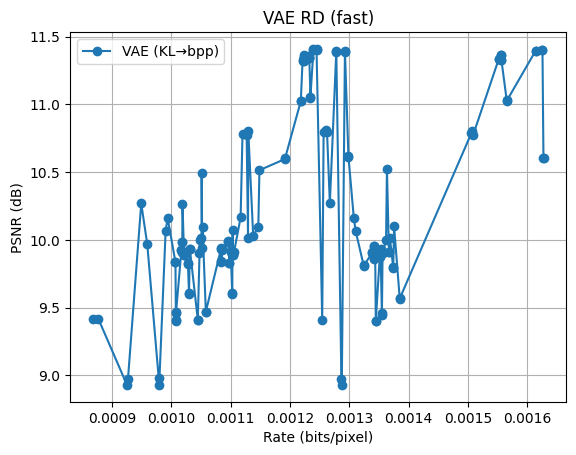

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rd_vae(points, title='VAE RD Curve'):
    if not points:
        print("No points to plot."); return
    xs = np.array([p['rate_bpp'] for p in points], dtype=float)
    ys = np.array([p['psnr'] for p in points], dtype=float)
    order = np.argsort(xs)
    xs, ys = xs[order], ys[order]
    plt.figure()
    plt.plot(xs, ys, '-o', label='VAE (KL→bpp)')
    plt.xlabel('Rate (bits/pixel)')
    plt.ylabel('PSNR (dB)')
    plt.title(title)
    plt.grid(True); plt.legend()
    plt.show()

plot_rd_vae(vae_points, title='VAE RD (fast)')


In [19]:
RUN_FFMPEG_BASELINES = False  # set True to run encodes (slower)

import subprocess, shutil, numpy as np

def has_ffmpeg():
    try:
        subprocess.run(['ffmpeg','-version'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
        return True
    except Exception:
        return False

def encode_dir(src_dir, out_dir, codec='x264', crfs=(26,30,34)):
    os.makedirs(out_dir, exist_ok=True)
    vids = _list_videos(src_dir)
    for v in vids:
        base = os.path.splitext(os.path.basename(v))[0]
        for crf in crfs:
            out = os.path.join(out_dir, f"{base}_crf{crf}.mp4")
            if codec=='x264':
                cmd = ['ffmpeg','-y','-i',v,'-c:v','libx264','-preset','medium','-crf',str(crf),'-pix_fmt','yuv420p', out]
            else:
                cmd = ['ffmpeg','-y','-i',v,'-c:v','libx265','-preset','medium','-crf',str(crf),'-pix_fmt','yuv420p', out]
            print("Running:", " ".join(cmd))
            subprocess.run(cmd, check=True)

def decode_frames(path):
    cap = cv2.VideoCapture(path); fs=[]; ok=True
    while ok:
        ok, f = cap.read()
        if ok: fs.append(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))
    cap.release(); return fs

def eval_ffmpeg(enc_root, ref_root):
    pts = []
    refs = _list_videos(ref_root)
    for ref in refs:
        base = os.path.splitext(os.path.basename(ref))[0]
        cands = sorted(glob.glob(os.path.join(enc_root, f"{base}*.*")))
        if not cands: continue
        ref_fs = decode_frames(ref)
        if not ref_fs: continue
        H,W = ref_fs[0].shape[:2]
        for enc in cands:
            enc_fs = decode_frames(enc)
            n = min(len(ref_fs), len(enc_fs))
            if n == 0: continue
            ps = []
            for i in range(n):
                x = ref_fs[i].astype('float32')/255.0
                y = enc_fs[i].astype('float32')/255.0
                mse = np.mean((x-y)**2)+1e-8
                ps.append(10*np.log10(1.0/mse))
            bits = os.path.getsize(enc)*8
            bpp = bits/(H*W*n)
            pts.append({'name': base, 'file': os.path.basename(enc), 'psnr': float(np.mean(ps)), 'rate_bpp': float(bpp)})
    return pts

if RUN_FFMPEG_BASELINES:
    assert has_ffmpeg(), "ffmpeg not found. Install via homebrew (macOS): brew install ffmpeg"
    os.makedirs("outputs/x264", exist_ok=True)
    os.makedirs("outputs/x265", exist_ok=True)
    encode_dir(DATA_VAL, "outputs/x264", codec='x264', crfs=(26,30,34))
    encode_dir(DATA_VAL, "outputs/x265", codec='x265', crfs=(28,32,36))
    x264_points = eval_ffmpeg("outputs/x264", DATA_VAL)
    x265_points = eval_ffmpeg("outputs/x265", DATA_VAL)
    print("x264 points:", len(x264_points), "x265 points:", len(x265_points))
else:
    x264_points = []
    x265_points = []
    print("Skipped ffmpeg baselines. Set RUN_FFMPEG_BASELINES=True to run them.")


Skipped ffmpeg baselines. Set RUN_FFMPEG_BASELINES=True to run them.


In [21]:
import os, subprocess, glob, cv2, numpy as np, math, matplotlib.pyplot as plt

# Choose your CRFs (lower CRF = higher quality, more bits)
X264_CRFS = (22, 26, 30, 34)
X265_CRFS = (24, 28, 32, 36)

VAL_DIR = DATA_VAL  # use your existing val folder
OUT_X264 = "outputs/x264"
OUT_X265 = "outputs/x265"
os.makedirs(OUT_X264, exist_ok=True)
os.makedirs(OUT_X265, exist_ok=True)

def has_ffmpeg():
    try:
        subprocess.run(["ffmpeg","-version"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
        return True
    except Exception:
        return False

print("ffmpeg present?", has_ffmpeg())
if not has_ffmpeg():
    print("⚠️ ffmpeg not found. On macOS: `brew install ffmpeg`. You can still run the VAE part.")


ffmpeg present? True


In [23]:
if has_ffmpeg():
    def list_videos(root, exts=(".mp4",".mov",".mkv",".avi",".webm",".y4m")):
        return sorted([p for p in glob.glob(os.path.join(root, "**/*"), recursive=True)
                       if os.path.isfile(p) and p.lower().endswith(exts)])
    val_vids = list_videos(VAL_DIR)
    print("Val vids:", [os.path.basename(v) for v in val_vids])

    # Encode with x264
    for v in val_vids:
        base = os.path.splitext(os.path.basename(v))[0]
        for crf in X264_CRFS:
            out = os.path.join(OUT_X264, f"{base}_crf{crf}.mp4")
            if os.path.exists(out): 
                print("skip (exists):", os.path.basename(out)); 
                continue
            cmd = ["ffmpeg","-y","-i",v,"-c:v","libx264","-preset","medium","-crf",str(crf),"-pix_fmt","yuv420p",out]
            print("x264:", os.path.basename(v), "CRF", crf)
            subprocess.run(cmd, check=True)

    # Encode with x265
    for v in val_vids:
        base = os.path.splitext(os.path.basename(v))[0]
        for crf in X265_CRFS:
            out = os.path.join(OUT_X265, f"{base}_crf{crf}.mp4")
            if os.path.exists(out): 
                print("skip (exists):", os.path.basename(out)); 
                continue
            cmd = ["ffmpeg","-y","-i",v,"-c:v","libx265","-preset","medium","-crf",str(crf),"-pix_fmt","yuv420p",out]
            print("x265:", os.path.basename(v), "CRF", crf)
            subprocess.run(cmd, check=True)
else:
    print("Skipping encodes (no ffmpeg).")


Val vids: ['big_buck_bunny_240p_1mb.mp4', 'big_buck_bunny_240p_2mb.mp4']
x264: big_buck_bunny_240p_1mb.mp4 CRF 22


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

x264: big_buck_bunny_240p_1mb.mp4 CRF 26


[out#0/mp4 @ 0x128e32950] video:138KiB audio:575KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 1.140187%
frame=  205 fps=0.0 q=-1.0 Lsize=     721KiB time=00:00:13.53 bitrate= 436.4kbits/s speed=34.6x    
[libx264 @ 0x128e33920] frame I:3     Avg QP:19.43  size:  8621
[libx264 @ 0x128e33920] frame P:107   Avg QP:22.75  size:   855
[libx264 @ 0x128e33920] frame B:95    Avg QP:23.80  size:   243
[libx264 @ 0x128e33920] consecutive B-frames: 32.7% 13.7%  8.8% 44.9%
[libx264 @ 0x128e33920] mb I  I16..4: 24.4% 32.7% 42.9%
[libx264 @ 0x128e33920] mb P  I16..4:  0.2%  1.0%  0.4%  P16..4: 21.8%  7.9%  5.3%  0.0%  0.0%    skip:63.4%
[libx264 @ 0x128e33920] mb B  I16..4:  0.0%  0.1%  0.1%  B16..8: 19.1%  2.8%  0.9%  direct: 0.7%  skip:76.3%  L0:42.5% L1:50.8% BI: 6.7%
[libx264 @ 0x128e33920] 8x8 transform intra:44.0% inter:57.2%
[libx264 @ 0x128e33920] coded y,uvDC,uvAC intra: 75.2% 80.6% 58.4% inter: 7.9% 8.1% 1.0%
[libx264 @ 0x128e33920] i16 v,h,dc,p: 11% 49% 29% 12%

x264: big_buck_bunny_240p_1mb.mp4 CRF 30


[out#0/mp4 @ 0x146719ab0] video:85KiB audio:575KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 1.231740%
frame=  205 fps=0.0 q=-1.0 Lsize=     668KiB time=00:00:13.53 bitrate= 404.4kbits/s speed=47.2x    
[libx264 @ 0x1467167c0] frame I:3     Avg QP:23.08  size:  5811
[libx264 @ 0x1467167c0] frame P:107   Avg QP:26.77  size:   497
[libx264 @ 0x1467167c0] frame B:95    Avg QP:26.74  size:   164
[libx264 @ 0x1467167c0] consecutive B-frames: 32.7% 13.7%  8.8% 44.9%
[libx264 @ 0x1467167c0] mb I  I16..4: 24.4% 49.8% 25.8%
[libx264 @ 0x1467167c0] mb P  I16..4:  0.2%  1.1%  0.3%  P16..4: 17.7%  6.1%  3.3%  0.0%  0.0%    skip:71.4%
[libx264 @ 0x1467167c0] mb B  I16..4:  0.0%  0.1%  0.0%  B16..8: 16.6%  1.9%  0.5%  direct: 0.4%  skip:80.4%  L0:40.8% L1:55.3% BI: 3.9%
[libx264 @ 0x1467167c0] 8x8 transform intra:57.9% inter:70.1%
[libx264 @ 0x1467167c0] coded y,uvDC,uvAC intra: 67.0% 71.6% 41.5% inter: 4.8% 4.7% 0.3%
[libx264 @ 0x1467167c0] i16 v,h,dc,p: 12% 46% 23% 19%


x264: big_buck_bunny_240p_1mb.mp4 CRF 34


[out#0/mp4 @ 0x141719c70] video:55KiB audio:575KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 1.290373%
frame=  205 fps=0.0 q=-1.0 Lsize=     638KiB time=00:00:13.53 bitrate= 386.3kbits/s speed=47.2x    
[libx264 @ 0x141718630] frame I:3     Avg QP:27.06  size:  3846
[libx264 @ 0x141718630] frame P:107   Avg QP:30.86  size:   312
[libx264 @ 0x141718630] frame B:95    Avg QP:29.91  size:   112
[libx264 @ 0x141718630] consecutive B-frames: 32.7% 13.7%  8.8% 44.9%
[libx264 @ 0x141718630] mb I  I16..4: 31.6% 52.6% 15.9%
[libx264 @ 0x141718630] mb P  I16..4:  0.3%  1.0%  0.2%  P16..4: 15.5%  3.7%  1.6%  0.0%  0.0%    skip:77.7%
[libx264 @ 0x141718630] mb B  I16..4:  0.0%  0.1%  0.0%  B16..8: 14.7%  1.2%  0.2%  direct: 0.2%  skip:83.5%  L0:42.3% L1:55.8% BI: 1.9%
[libx264 @ 0x141718630] 8x8 transform intra:59.2% inter:80.2%
[libx264 @ 0x141718630] coded y,uvDC,uvAC intra: 56.7% 65.4% 26.6% inter: 2.8% 2.8% 0.1%
[libx264 @ 0x141718630] i16 v,h,dc,p: 13% 48% 20% 19%


x264: big_buck_bunny_240p_2mb.mp4 CRF 22


[out#0/mp4 @ 0x12b81ab50] video:430KiB audio:1121KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.940897%
frame=  402 fps=0.0 q=-1.0 Lsize=    1565KiB time=00:00:26.66 bitrate= 480.8kbits/s speed=48.7x    
[libx264 @ 0x12b819510] frame I:7     Avg QP:15.02  size: 14825
[libx264 @ 0x12b819510] frame P:203   Avg QP:19.37  size:  1261
[libx264 @ 0x12b819510] frame B:192   Avg QP:21.00  size:   417
[libx264 @ 0x12b819510] consecutive B-frames: 30.6% 13.9%  9.7% 45.8%
[libx264 @ 0x12b819510] mb I  I16..4: 14.0% 29.0% 57.1%
[libx264 @ 0x12b819510] mb P  I16..4:  0.2%  1.5%  0.7%  P16..4: 23.9%  9.3%  7.0%  0.0%  0.0%    skip:57.3%
[libx264 @ 0x12b819510] mb B  I16..4:  0.1%  0.5%  0.2%  B16..8: 17.8%  4.3%  1.6%  direct: 1.1%  skip:74.5%  L0:44.7% L1:42.7% BI:12.6%
[libx264 @ 0x12b819510] 8x8 transform intra:45.1% inter:50.4%
[libx264 @ 0x12b819510] coded y,uvDC,uvAC intra: 79.2% 86.7% 70.5% inter: 11.2% 11.8% 1.9%
[libx264 @ 0x12b819510] i16 v,h,dc,p:  6% 43% 33% 

x264: big_buck_bunny_240p_2mb.mp4 CRF 26


[out#0/mp4 @ 0x138e34b50] video:274KiB audio:1121KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 1.046221%
frame=  402 fps=0.0 q=-1.0 Lsize=    1409KiB time=00:00:26.66 bitrate= 432.9kbits/s speed=49.3x    
[libx264 @ 0x138e35960] frame I:7     Avg QP:18.93  size: 10560
[libx264 @ 0x138e35960] frame P:203   Avg QP:23.21  size:   752
[libx264 @ 0x138e35960] frame B:192   Avg QP:23.91  size:   277
[libx264 @ 0x138e35960] consecutive B-frames: 30.6% 13.9%  9.7% 45.8%
[libx264 @ 0x138e35960] mb I  I16..4: 19.2% 36.5% 44.2%
[libx264 @ 0x138e35960] mb P  I16..4:  0.4%  1.6%  0.5%  P16..4: 19.5%  8.1%  5.1%  0.0%  0.0%    skip:64.9%
[libx264 @ 0x138e35960] mb B  I16..4:  0.1%  0.5%  0.1%  B16..8: 16.2%  3.3%  1.0%  direct: 0.7%  skip:78.0%  L0:44.9% L1:47.1% BI: 7.9%
[libx264 @ 0x138e35960] 8x8 transform intra:50.3% inter:64.6%
[libx264 @ 0x138e35960] coded y,uvDC,uvAC intra: 72.7% 82.0% 57.1% inter: 7.0% 7.2% 0.7%
[libx264 @ 0x138e35960] i16 v,h,dc,p: 10% 42% 25% 23

x264: big_buck_bunny_240p_2mb.mp4 CRF 30


[out#0/mp4 @ 0x144817630] video:178KiB audio:1121KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 1.123792%
frame=  402 fps=0.0 q=-1.0 Lsize=    1313KiB time=00:00:26.66 bitrate= 403.3kbits/s speed=47.3x    
[libx264 @ 0x1448142e0] frame I:7     Avg QP:22.66  size:  7340
[libx264 @ 0x1448142e0] frame P:203   Avg QP:26.99  size:   461
[libx264 @ 0x1448142e0] frame B:192   Avg QP:26.80  size:   189
[libx264 @ 0x1448142e0] consecutive B-frames: 30.6% 13.9%  9.7% 45.8%
[libx264 @ 0x1448142e0] mb I  I16..4: 20.3% 50.0% 29.8%
[libx264 @ 0x1448142e0] mb P  I16..4:  0.4%  1.7%  0.3%  P16..4: 17.0%  6.1%  2.8%  0.0%  0.0%    skip:71.7%
[libx264 @ 0x1448142e0] mb B  I16..4:  0.1%  0.4%  0.1%  B16..8: 14.5%  2.4%  0.6%  direct: 0.4%  skip:81.6%  L0:45.1% L1:49.6% BI: 5.2%
[libx264 @ 0x1448142e0] 8x8 transform intra:59.0% inter:75.1%
[libx264 @ 0x1448142e0] coded y,uvDC,uvAC intra: 64.2% 74.0% 43.7% inter: 4.4% 4.1% 0.2%
[libx264 @ 0x1448142e0] i16 v,h,dc,p: 13% 41% 21% 25

x264: big_buck_bunny_240p_2mb.mp4 CRF 34


[out#0/mp4 @ 0x126f38e60] video:119KiB audio:1121KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 1.177518%
frame=  402 fps=0.0 q=-1.0 Lsize=    1254KiB time=00:00:26.66 bitrate= 385.1kbits/s speed=48.7x    
[libx264 @ 0x126f35b20] frame I:7     Avg QP:26.43  size:  4983
[libx264 @ 0x126f35b20] frame P:203   Avg QP:30.70  size:   301
[libx264 @ 0x126f35b20] frame B:192   Avg QP:29.88  size:   128
[libx264 @ 0x126f35b20] consecutive B-frames: 30.6% 13.9%  9.7% 45.8%
[libx264 @ 0x126f35b20] mb I  I16..4: 26.8% 53.5% 19.8%
[libx264 @ 0x126f35b20] mb P  I16..4:  0.5%  1.5%  0.2%  P16..4: 15.5%  3.8%  1.5%  0.0%  0.0%    skip:77.0%
[libx264 @ 0x126f35b20] mb B  I16..4:  0.1%  0.3%  0.0%  B16..8: 12.6%  1.6%  0.3%  direct: 0.3%  skip:84.8%  L0:45.9% L1:51.3% BI: 2.8%
[libx264 @ 0x126f35b20] 8x8 transform intra:60.0% inter:82.6%
[libx264 @ 0x126f35b20] coded y,uvDC,uvAC intra: 55.4% 67.1% 31.7% inter: 2.6% 2.5% 0.1%
[libx264 @ 0x126f35b20] i16 v,h,dc,p: 13% 43% 18% 26

x265: big_buck_bunny_240p_1mb.mp4 CRF 24


[out#0/mp4 @ 0x15c00b650] video:175KiB audio:575KiB subtitle:0KiB other streams:0KiB global headers:2KiB muxing overhead: 1.460744%
frame=  205 fps=0.0 q=29.9 Lsize=     761KiB time=00:00:13.53 bitrate= 460.7kbits/s speed=24.2x    
x265 [info]: frame I:      3, Avg QP:18.98  kb/s: 1149.48 
x265 [info]: frame P:     68, Avg QP:23.31  kb/s: 202.76  
x265 [info]: frame B:    134, Avg QP:29.50  kb/s: 31.17   
x265 [info]: Weighted P-Frames: Y:0.0% UV:0.0%

encoded 205 frames in 0.55s (372.64 fps), 104.46 kb/s, Avg QP:27.29
[aac @ 0x15c0599a0] Qavg: 963.050
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --

x265: big_buck_bunny_240p_1mb.mp4 CRF 28


[out#0/mp4 @ 0x1371178a0] video:104KiB audio:575KiB subtitle:0KiB other streams:0KiB global headers:2KiB muxing overhead: 1.613780%
frame=  205 fps=0.0 q=33.8 Lsize=     690KiB time=00:00:13.53 bitrate= 417.7kbits/s speed=32.5x    
x265 [info]: frame I:      3, Avg QP:22.92  kb/s: 800.88  
x265 [info]: frame P:     68, Avg QP:27.79  kb/s: 111.58  
x265 [info]: frame B:    134, Avg QP:33.52  kb/s: 20.01   
x265 [info]: Weighted P-Frames: Y:0.0% UV:0.0%

encoded 205 frames in 0.41s (497.73 fps), 61.81 kb/s, Avg QP:31.47
[aac @ 0x137159660] Qavg: 963.050
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --e

x265: big_buck_bunny_240p_1mb.mp4 CRF 32


[out#0/mp4 @ 0x14c71a670] video:64KiB audio:575KiB subtitle:0KiB other streams:0KiB global headers:2KiB muxing overhead: 1.715799%
frame=  205 fps=0.0 q=38.0 Lsize=     650KiB time=00:00:13.53 bitrate= 393.2kbits/s speed=40.2x    
x265 [info]: frame I:      3, Avg QP:26.94  kb/s: 543.28  
x265 [info]: frame P:     68, Avg QP:32.25  kb/s: 63.48   
x265 [info]: frame B:    134, Avg QP:37.56  kb/s: 13.16   
x265 [info]: Weighted P-Frames: Y:0.0% UV:0.0%

encoded 205 frames in 0.33s (617.04 fps), 37.61 kb/s, Avg QP:35.64
[aac @ 0x14c75c570] Qavg: 963.050
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --en

x265: big_buck_bunny_240p_1mb.mp4 CRF 36


[out#0/mp4 @ 0x11d629900] video:40KiB audio:575KiB subtitle:0KiB other streams:0KiB global headers:2KiB muxing overhead: 1.780419%
frame=  205 fps=0.0 q=42.0 Lsize=     626KiB time=00:00:13.53 bitrate= 379.2kbits/s speed=43.6x    
x265 [info]: frame I:      3, Avg QP:30.95  kb/s: 359.12  
x265 [info]: frame P:     68, Avg QP:36.71  kb/s: 38.44   
x265 [info]: frame B:    134, Avg QP:41.60  kb/s: 8.74    
x265 [info]: Weighted P-Frames: Y:0.0% UV:0.0%

encoded 205 frames in 0.31s (671.45 fps), 23.72 kb/s, Avg QP:39.82
[aac @ 0x11d761c20] Qavg: 963.050
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --en

x265: big_buck_bunny_240p_2mb.mp4 CRF 24


[out#0/mp4 @ 0x136e2a000] video:326KiB audio:1121KiB subtitle:0KiB other streams:0KiB global headers:2KiB muxing overhead: 1.231996%
frame=  402 fps=0.0 q=29.9 Lsize=    1464KiB time=00:00:26.66 bitrate= 449.9kbits/s speed=30.6x    
x265 [info]: frame I:      7, Avg QP:18.35  kb/s: 1307.30 
x265 [info]: frame P:    127, Avg QP:23.59  kb/s: 171.69  
x265 [info]: frame B:    268, Avg QP:29.48  kb/s: 33.29   
x265 [info]: Weighted P-Frames: Y:0.0% UV:0.0%

encoded 402 frames in 0.87s (463.08 fps), 99.20 kb/s, Avg QP:27.43
[aac @ 0x136e7cf40] Qavg: 770.219
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --

x265: big_buck_bunny_240p_2mb.mp4 CRF 28


[out#0/mp4 @ 0x135646b80] video:206KiB audio:1121KiB subtitle:0KiB other streams:0KiB global headers:2KiB muxing overhead: 1.343743%
frame=  402 fps=0.0 q=33.9 Lsize=    1344KiB time=00:00:26.66 bitrate= 412.9kbits/s speed=35.1x    
x265 [info]: frame I:      7, Avg QP:22.34  kb/s: 925.44  
x265 [info]: frame P:    127, Avg QP:28.07  kb/s: 100.46  
x265 [info]: frame B:    268, Avg QP:33.50  kb/s: 21.86   
x265 [info]: Weighted P-Frames: Y:0.0% UV:0.0%

encoded 402 frames in 0.76s (532.25 fps), 62.42 kb/s, Avg QP:31.59
[aac @ 0x135688760] Qavg: 770.219
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --

x265: big_buck_bunny_240p_2mb.mp4 CRF 32


[out#0/mp4 @ 0x141646f60] video:133KiB audio:1121KiB subtitle:0KiB other streams:0KiB global headers:2KiB muxing overhead: 1.422081%
frame=  402 fps=0.0 q=38.3 Lsize=    1271KiB time=00:00:26.66 bitrate= 390.5kbits/s speed=39.2x    
x265 [info]: frame I:      7, Avg QP:26.30  kb/s: 637.27  
x265 [info]: frame P:    127, Avg QP:32.49  kb/s: 60.76   
x265 [info]: frame B:    268, Avg QP:37.55  kb/s: 14.70   
x265 [info]: Weighted P-Frames: Y:0.0% UV:0.0%

encoded 402 frames in 0.68s (595.46 fps), 40.09 kb/s, Avg QP:35.75
[aac @ 0x141688b40] Qavg: 770.219


x265: big_buck_bunny_240p_2mb.mp4 CRF 36


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

VAE pts   : 153
x264 pts  : 0
x265 pts  : 0
[WARN] No plottable points for H.264.
[WARN] No plottable points for H.265.


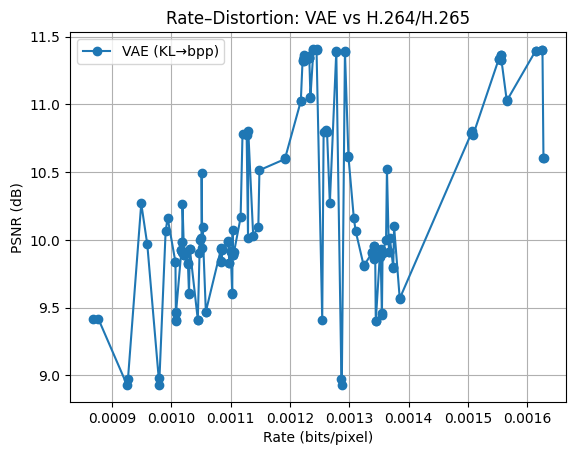

In [22]:
def decode_all_frames(path):
    cap = cv2.VideoCapture(path)
    frames = []
    ok = True
    while ok:
        ok, f = cap.read()
        if ok:
            frames.append(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))
    cap.release()
    return frames

def psnr_frames(ref_frames, enc_frames):
    n = min(len(ref_frames), len(enc_frames))
    if n == 0: return float("nan")
    vals = []
    for i in range(n):
        r = ref_frames[i].astype(np.float32)/255.0
        e = enc_frames[i].astype(np.float32)/255.0
        # resize encoded to ref size if needed
        if e.shape != r.shape:
            e = cv2.resize(e, (r.shape[1], r.shape[0]), interpolation=cv2.INTER_AREA)
        mse = np.mean((r - e)**2) + 1e-8
        vals.append(10.0 * math.log10(1.0/mse))
    return float(np.mean(vals))

def bpp_filebits(path, H, W, N):
    bits = os.path.getsize(path) * 8.0
    return bits / (H*W*N + 1e-12)

def eval_codec_dir(enc_dir, ref_dir):
    points = []
    ref_list = sorted([p for p in glob.glob(os.path.join(ref_dir, "*")) if os.path.isfile(p)])
    for ref in ref_list:
        base = os.path.splitext(os.path.basename(ref))[0]
        ref_frames = decode_all_frames(ref)
        if not ref_frames:
            continue
        H, W = ref_frames[0].shape[:2]
        cand = sorted(glob.glob(os.path.join(enc_dir, f"{base}_crf*.mp4")))
        for enc in cand:
            enc_frames = decode_all_frames(enc)
            n = min(len(ref_frames), len(enc_frames))
            if n == 0: 
                continue
            p = psnr_frames(ref_frames, enc_frames)
            r = bpp_filebits(enc, H, W, n)
            points.append({"name": base, "file": os.path.basename(enc), "psnr": p, "rate_bpp": r})
    return points

# Collect points
if has_ffmpeg():
    x264_points = eval_codec_dir(OUT_X264, VAL_DIR)
    x265_points = eval_codec_dir(OUT_X265, VAL_DIR)
else:
    x264_points, x265_points = [], []

print("VAE pts   :", len(vae_points))
print("x264 pts  :", len(x264_points))
print("x265 pts  :", len(x265_points))

# Robust plotting (handles empty lists)
def safe_rd(points, label):
    pts = [p for p in points if np.isfinite(p.get("rate_bpp", np.nan)) and np.isfinite(p.get("psnr", np.nan))]
    if not pts:
        print(f"[WARN] No plottable points for {label}.")
        return None, None
    xs = np.array([p["rate_bpp"] for p in pts], float)
    ys = np.array([p["psnr"]    for p in pts], float)
    o = np.argsort(xs)
    return xs[o], ys[o]

plt.figure()
vx, vy = safe_rd(vae_points, "VAE")
if vx is not None: plt.plot(vx, vy, "-o", label="VAE (KL→bpp)")

rx, ry = safe_rd(x264_points, "H.264")
if rx is not None: plt.plot(rx, ry, "-o", label="H.264 (x264)")

kx, ky = safe_rd(x265_points, "H.265")
if kx is not None: plt.plot(kx, ky, "-o", label="H.265 (x265)")

plt.xlabel("Rate (bits/pixel)")
plt.ylabel("PSNR (dB)")
plt.title("Rate–Distortion: VAE vs H.264/H.265")
plt.grid(True); plt.legend(); plt.show()
